In [1]:
#Import the necessary methods from tweepy library
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import csv
from collections import Counter
#from config import *
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor
import datetime

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag

import time
from collections import defaultdict
import collections
from numpy import linalg as la
import re
import math
import ast

In [2]:
data=pd.read_csv('clustering.csv')
data.text=data.text.apply(lambda x: ast.literal_eval(x))
data.head()

,text,user,url,original_text,date,hashtags,likes,retweets,Cluster
0,"[hey, houston, #washyourhand, #stayhomestaysaf...",33019,https://twitter.com/MTrujil35563249/status/133...,"Hey, Houston #WashYourHands #StayHomeStaySafe ...",Sat Nov 21 23:59:59 +0000 2020,"[{'text': 'WashYourHands', 'indices': [13, 27]...",0,0,0
1,"[told, grey, need, remind, covid]",81446,https://twitter.com/kaixoxokai/status/13302999...,Who told Greys we needed more reminders of covid,Sat Nov 21 23:59:59 +0000 2020,[],4,0,0
2,"[recent, report, show, #hospit, across, countr...",43087,https://twitter.com/RaveMSafety/status/1330299...,Recent reports show #hospitals across the coun...,Sat Nov 21 23:59:59 +0000 2020,"[{'text': 'hospitals', 'indices': [20, 30]}]",1,0,5
3,"[shout, fellow, covid, longterm, survivor, wee...",1035,https://twitter.com/6MonstersMake8/status/1330...,Shout out to my fellow Covid long-term survivo...,Sat Nov 21 23:59:59 +0000 2020,[],0,0,0
4,"[moment, strength, bout, covid, use, write, fa...",1035,https://twitter.com/6MonstersMake8/status/1330...,I had a moment of strength during my bout of C...,Sat Nov 21 23:59:58 +0000 2020,[],0,0,0


In [3]:
def read_dict_to_file(filename):
    with open(filename, 'r') as file:
        aux = file.read()
    return json.loads(aux)

# Read index, tf and idf from files
index = read_dict_to_file('index.json')
tf = read_dict_to_file('tf.json')
idf =read_dict_to_file('idf.json')

In [4]:
punctuation = string.punctuation.replace('#','').replace('@','')+'…'
def preprocess_tweet(tweets_series):
    # Lowercasing text
    tweets_series = tweets_series.apply(lambda x: x.lower())

    # Remove URLS (https and www), mentions and rt
    tweets_series = tweets_series.apply(lambda x: re.sub(r'https?//\S+|www.\S+|@\w*|^rt','', x))
    
    #Removing numbers
    tweets_series=tweets_series.apply(lambda x: re.sub(r"([0-9])",'', x))

    # Remove punctuation except # (hashtags)
    tweets_series = tweets_series.apply(lambda x: "".join([char for char in x if char not in punctuation]))

    # Replacing symbol ’ for ' as they mean the same and it is needed to correctly remove stopwords
    tweets_series = tweets_series.apply(lambda x: x.replace("’","").replace('“',"").replace('”',''))
    
    #Removing emojis
    tweets_series=tweets_series.apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))

    # Tokenize text 
    tweets_series = tweets_series.apply(lambda x: x.split())

    # Removing stop words
    stop_words = stopwords.words('english')
    tweets_series = tweets_series.apply(lambda x: [word for word in x if word not in stop_words])
                
    # Stemming
    porter = PorterStemmer()
    tweets_series = tweets_series.apply(lambda x: [porter.stem(word) for word in x]) 

    return tweets_series

# Search Engine Build 

In [5]:
def rankDocuments(query_terms, docs, index, idf, tf, method='tf-idf'):
    """
    Perform the ranking of the results of a search based with tf-idf or popular (own score)
    
    Argument:
    query_terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    
    Returns:
    Print the list of ranked documents
    """
    global data
    df = data.iloc[docs,:]    
    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaing elements would became 0 when multiplied to the queryVector
    docVectors=defaultdict(lambda: [0]*len(query_terms)) # I call docVectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    queryVector=[0]*len(query_terms)    

    # compute the norm for the query tf
    query_terms_count = collections.Counter(query_terms) # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    
    # HINT: use when computing tf for queryVector   
    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(query_terms): #termIndex is the index of the term in the query
        if term not in index:
            continue
                    
        ## Compute tf*idf(normalize tf as done with documents)
        queryVector[termIndex]=query_terms_count[term]/query_norm * idf[term] 

        # Generate docVectors for matching docs
        for docIndex, (doc, postings) in enumerate(index[term]):
            # Example of [docIndex, (doc, postings)]
            # 0 ([26, 2],[34,1])
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....
            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                docVectors[doc][termIndex]=tf[term][docIndex] #* idf[term]  # TODO: check if multiply for idf
                
    # calculate the score of each doc
    # compute the cosine similarity between queryVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine siilarity
    # see np.dot
    
    if method == 'popular':
        docScores=[ [0.4*np.dot(curDocVec, queryVector) + 0.3*np.log(data['likes'].loc[doc] + 1)/np.log(data['likes'].max() + 1) +0.3*np.log(data.retweets.loc[doc] + 1)/np.log(data.retweets.max() + 1) ,doc] for doc, curDocVec in docVectors.items() ]
        
    elif (method == 'disparity'):
        docScores=[ [0.4*np.dot(curDocVec, queryVector) + 0.3*np.log(data['likes'].loc[doc] + 1)/np.log(data['likes'].max() + 1) +0.3*np.log(data.retweets.loc[doc] + 1)/np.log(data.retweets.max() + 1) - (df.Cluster.value_counts()/df.Cluster.value_counts().sum())[df.loc[doc,'Cluster']]*0.356 ,doc] for doc, curDocVec in docVectors.items() ]
        
    else:
        docScores=[ [np.dot(curDocVec, queryVector),doc] for doc, curDocVec in docVectors.items() ]
    
   
    docScores.sort(reverse=True)
    resultDocs=[x[1] for x in docScores]
    
    if len(resultDocs) == 0:
        print("No results found, try again\n")
        query = input("Insert your query:")
        resultDocs = search_tf_idf(query, index, method)    
    #print ('\n'.join(resultDocs), '\n')
    
    return resultDocs

In [6]:
def search_tf_idf(query, index, method):
    '''
    output is the list of documents that contain all of the query terms. 
    So, we will get the list of documents for each query term, and take the intersection of them.
    '''
    query=preprocess_tweet(pd.Series(query)).values[0]

    docs=set()
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"
            termDocs=[posting[0] for posting in index[term]]

            # Set containing docs with all query terms
            if len(docs) == 0:
                docs = docs.union(termDocs) 
            else:
                docs = docs.intersection(termDocs)
        except:
            #term is not in index
            pass
    docs=list(docs)
    ranked_docs = rankDocuments(query, docs, index, idf, tf, method)

    return ranked_docs


In [7]:
query = input("Insert your query:")
ranked_docs = search_tf_idf(query, index, method='disparity')    
top = 10
results_df = data.loc[ranked_docs[:top]][['original_text','url','user','date','hashtags','retweets','Cluster','likes']]

print('=======================================\n')
for ind, row in results_df.iterrows():
    print('Tweet ID:',ind,'  URL:',row.url)
    print('Date:',row.date)
    print('User:',row.user,'  Hashtags:',row.hashtags)
    print('Cluster:',row.Cluster,'  Retweets:',row.retweets,'  Likes:',row.likes)
    print('Tweet:',row.original_text)
    print('\n=======================================\n')



Tweet ID: 17678   URL: https://twitter.com/DJImmekus/status/1331743463440728064
Date: Wed Nov 25 23:35:58 +0000 2020
User: 12849   Hashtags: []
Cluster: -1   Retweets: 0   Likes: 1
Tweet: Government helping with Covid lockdowns ...... https//t.co/qZpvvbz7LD


Tweet ID: 15537   URL: https://twitter.com/alaubsch/status/1331745092323995648
Date: Wed Nov 25 23:42:27 +0000 2020
User: 59492   Hashtags: []
Cluster: 11   Retweets: 0   Likes: 1
Tweet: Lockdowns vs. COVID19 Covid Wins https//t.co/Lx5kZhraJ8


Tweet ID: 9396   URL: https://twitter.com/dennisclang/status/1330293553860370440
Date: Sat Nov 21 23:34:33 +0000 2020
User: 69475   Hashtags: []
Cluster: 6   Retweets: 0   Likes: 0
Tweet: @91491 @15352 The PCR testing was just after the end of lockdowns, anyone who had had COVID was likely t… https//t.co/ACYHGcSOxx


Tweet ID: 3267   URL: https://twitter.com/MRSS11224611/status/1330297654014832641
Date: Sat Nov 21 23:50:51 +0000 2020
User: 32925   Hashtags: []
Cluster: 8   Retweets: 0   Li

In [8]:
queries_list=["trump","quarantine","covid lockdown"]

In [9]:
with open('with_diversification_queries.tsv','w', encoding='utf-8') as f:
    for query in queries_list:
        # Using tf-idf
        ranked_docs = search_tf_idf(query, index, method='disparity')    
        top = 20
        results_df = data.loc[ranked_docs[:top]][['original_text','url','user','date','hashtags','likes','retweets','Cluster']]
        f.write('Query:'+query+'\n')
        f.write('=======================================\n')
        for ind, row in results_df.iterrows():
            f.write('Tweet ID: '+str(ind)+'  URL: '+str(row.url)+'\n')
            f.write('Date: '+str(row.date)+'\n')
            f.write('User: '+str(row.user)+'  Hashtags: '+str(row.hashtags)+'\n')
            f.write('Likes: '+str(row.likes)+'  Retweets: '+str(row.retweets)+'  Cluster: '+str(row.Cluster)+'\n')
            f.write('Tweet: '+str(row.original_text)+'\n')
            f.write('=======================================\n')
        f.writelines('\n\n\n')


In [10]:
with open('without_diversification_queries.tsv','w', encoding='utf-8') as f:
    for query in queries_list:
        # Using tf-idf
        ranked_docs = search_tf_idf(query, index, method='popular')    
        top = 20
        results_df = data.loc[ranked_docs[:top]][['original_text','url','user','date','hashtags','likes','retweets','Cluster']]
        f.write('Query:'+query+'\n')
        f.write('=======================================\n')
        for ind, row in results_df.iterrows():
            f.write('Tweet ID: '+str(ind)+'  URL: '+str(row.url)+'\n')
            f.write('Date: '+str(row.date)+'\n')
            f.write('User: '+str(row.user)+'  Hashtags: '+str(row.hashtags)+'\n')
            f.write('Likes: '+str(row.likes)+'  Retweets: '+str(row.retweets)+'  Cluster: '+str(row.Cluster)+'\n')
            f.write('Tweet: '+str(row.original_text)+'\n')
            f.write('=======================================\n')
        f.writelines('\n\n\n')


In [11]:
with_disparity = []
for query in queries_list:
    # Using tf-idf
    ranked_docs = search_tf_idf(query, index, method='disparity')    
    top = 20
    results_df = data.loc[ranked_docs[:top]][['original_text','url','user','date','hashtags','likes','retweets','Cluster']]
    print('=======================================\n')
    for ind, row in results_df.iterrows():
        with_disparity.append(row.Cluster)

In [12]:
without_disparity = []
for query in queries_list:
    # Using tf-idf
    ranked_docs = search_tf_idf(query, index, method='popular')    
    top = 20
    results_df = data.loc[ranked_docs[:top]][['original_text','url','user','date','hashtags','likes','retweets','Cluster']]
    print('=======================================\n')
    for ind, row in results_df.iterrows():
        without_disparity.append(row.Cluster)

In [13]:
qq = np.repeat(queries_list,20)

In [14]:
percentile_list = pd.DataFrame(
    {'with disparity': with_disparity,
     'without disparity': without_disparity},index=qq)

In [15]:
Q1 = percentile_list[percentile_list.index==queries_list[0]]
Q2 = percentile_list[percentile_list.index==queries_list[1]]
Q3 = percentile_list[percentile_list.index==queries_list[2]]

## Query 1 results

In [37]:
Q1

,with disparity,without disparity
trump,6,0
trump,-1,0
trump,4,0
trump,4,0
trump,12,0
trump,4,0
trump,4,0
trump,0,0
trump,4,0
trump,0,0


In [33]:
cmap = sns.diverging_palette(250, 10, as_cmap=True)

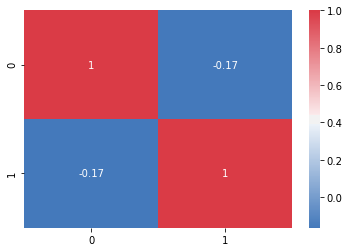

In [34]:
sns.heatmap(np.corrcoef(Q1.values.T),cmap=cmap, annot=True)  #Rankingdifference
plt.show()

In [18]:
[len(Q1[x].unique()) for x in Q1.columns]      #Coverage

[5, 4]

## Query 2 results

In [38]:
Q2

,with disparity,without disparity
quarantine,10,10
quarantine,10,10
quarantine,10,10
quarantine,10,10
quarantine,10,10
quarantine,10,10
quarantine,10,10
quarantine,10,10
quarantine,3,10
quarantine,-1,10


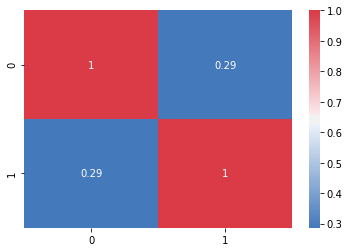

In [35]:
sns.heatmap(np.corrcoef(Q2.values.T),cmap=cmap, annot=True)  #Rankingdifference
plt.show()

In [21]:
[ len(Q2[x].unique()) for x in Q2.columns]      #Coverage

[3, 2]

## Query 3 results

In [39]:
Q3                               

,with disparity,without disparity
covid lockdown,-1,0
covid lockdown,11,0
covid lockdown,6,0
covid lockdown,8,0
covid lockdown,-1,-1
covid lockdown,-1,0
covid lockdown,-1,0
covid lockdown,8,0
covid lockdown,8,0
covid lockdown,8,0


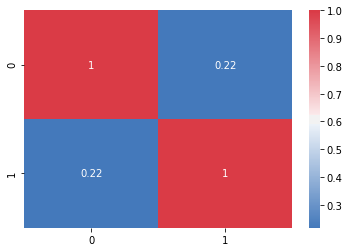

In [36]:
sns.heatmap(np.corrcoef(Q3.values.T),cmap=cmap, annot=True)  #Rankingdifference
plt.show()

In [24]:
[ len(Q3[x].unique()) for x in Q3.columns]   #Coverage

[7, 2]